In [7]:
# NEED THIS TO SAVE TO BIGGER DRIVE
import os
os.environ['HF_HOME'] = '/datastor1/jiahuikchen/hf_cache'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image
import torch
import random
from torchvision.transforms import v2

In [2]:
# cutmix/mixup
cutmix = v2.CutMix(num_classes=1)
mixup = v2.MixUp(num_classes=1)
preprocess = v2.Compose([
    v2.PILToTensor(), 
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)
])

img_txt_pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, 
)
img_txt_pipe = img_txt_pipe.to("cuda:0")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

### Implementation from [`diffusers/image_gen/gen_images.py`](https://github.com/JiahuiKChen/diffusers/blob/main/image_gen/gen_images.py)

In [16]:
# A40 
PROMPT_FILE = "/datastor1/jiahuikchen/diffusers/image_gen/imagenet_lt_balance_counts.txt"
TRAIN_DATA_TXT = "/datastor1/jiahuikchen/diffusers/image_gen/ImageNet_LT_train.txt"
TRAIN_DATA_ROOT = "/datastor1/imagenet2012_manual"
# OUTPUT_DIR = "/datastor1/jiahuikchen/dropout"

# read in long-tail training data file, 
# construct dict: {int class label: <list of image paths>}
# used to get training data images to condition generative model on
TRAIN_DICT = {}
with open(TRAIN_DATA_TXT) as train_file:
    for line in train_file:
        info = line.split() 
        class_label = int(info[1])
        img_path = info[0]

        if class_label in TRAIN_DICT:
            TRAIN_DICT[class_label].append(img_path)
        else:
            TRAIN_DICT[class_label] = [img_path]
            
# read in file with integer labels and text labesl
CLASS_DICT = {}
with open(PROMPT_FILE) as gen_file:
    # each line of this file contains the label (text label is the prompt) and how many images need to be generated
    lines = [line.rstrip('\n') for line in gen_file]

    for line in lines:
        l = line.split("\"")
        int_label = int(l[0].strip()); txt_label = l[1].strip("\""); 
        if int_label not in CLASS_DICT:
            CLASS_DICT[int_label] = txt_label
        else:
            raise ValueError("same class encountered twice in int label to text label file")

            
############################################################ METHODS
# randomly select one image of given class 
def get_rand_img(class_label):
    train_imgs = TRAIN_DICT[class_label]
    img_path = random.choice(train_imgs)
    img = load_image(os.path.join(TRAIN_DATA_ROOT, img_path))
    return img

# randomly select 2 images from given class,
# perform cutmix on them and return the cutmixed image
def cutmix_or_mixup(class_label, use_cutmix=True, use_mixup=False):
    img_1 = get_rand_img(class_label)
    img_2 = get_rand_img(class_label)
    dummy_images = torch.stack((preprocess(img_1), preprocess(img_2)))
    dummy_labels = torch.zeros(size=(2,)).to(torch.int64)
    cond_img = None
    if use_cutmix:
        cutmixed_img, _ = cutmix(dummy_images, dummy_labels)
        cond_img = cutmixed_img[0]
    elif use_mixup:
        mixuped_img, _ = mixup(dummy_images, dummy_labels)
        cond_img = mixuped_img[0]
    return v2.functional.to_pil_image(cond_img), img_1, img_2

# choose random train image and apply dropout
def get_dropout_img(class_label, dropout_prob=0.4):
    train_img = get_rand_img(class_label)
    noise_level = torch.tensor([0], device=img_txt_pipe._execution_device)
    image_embeds = img_txt_pipe._encode_image(
        image=train_img,
        device=img_txt_pipe._execution_device,
        batch_size=4,
        num_images_per_prompt=4,
        do_classifier_free_guidance=True,
        noise_level=noise_level,
        generator=None,
        image_embeds=None,
    )
        
    image_embeds = torch.nn.functional.dropout(image_embeds, p=dropout_prob, training=True) * (1 - dropout_prob)
#     dropout_img = img_txt_pipe.vae.decode(image_embeds / img_txt_pipe.vae.config.scaling_factor, return_dict=False)[0]
    return v2.functional.to_pil_image(image_embeds), train_img

In [39]:
# modified to just sample 1 prompt and training image
# and apply ALL conditionings
# and visualize ALL condition's generations 
def gen_imgs(label=None, dropout=True, use_cutmix=True, use_mixup=True):
    # if given a label, find its txt prompt + randomly select training image
    if not label:
        label = random.choice(list(CLASS_DICT.keys()))
    txt_prompt =  CLASS_DICT[label]
    
    # do and show ALL conditioning images w/ each method
    # random training image of same class
    rand_img = get_rand_img(label)
    # mixup 
    mixup_img, mixup_img_1, mixup_img_2 = cutmix_or_mixup(label, use_cutmix=False, use_mixup=True)
    # cutmix 
    cutmix_img, cutmix_img_1, cutmix_img_2 = cutmix_or_mixup(label, use_cutmix=True, use_mixup=False)
    # dropout 
    dropout_img, train_img = get_dropout_img(label)
    
    # get generations
    cutmix_imgs = img_txt_pipe(cutmix_img, txt_prompt, dropout=False, num_images_per_prompt=4).images
    mixup_imgs = img_txt_pipe(mixup_img, txt_prompt, dropout=False, num_images_per_prompt=4).images
    dropout_imgs = img_txt_pipe(train_img, txt_prompt, dropout=True, num_images_per_prompt=4).images
    rand_img_cond_imgs = img_txt_pipe(rand_img, txt_prompt, dropout=True, num_images_per_prompt=4).images
    
    # cutmix
    print(f"Prompt: {txt_prompt}")
    plt.figure(figsize=(3,3))
    plt.imshow(cutmix_img); plt.axis("off"); plt.title("Cutmix Conditioning Image");
    f, axarr = plt.subplots(1,2, figsize=(17, 17))
    axarr[0].imshow(cutmix_img_1); axarr[0].axis("off"); axarr[0].set_title(f"Cutmix-ed Image 1")
    axarr[1].imshow(cutmix_img_2); axarr[1].axis("off"); axarr[1].set_title(f"Cutmix-ed Image 2")
    f, axarr = plt.subplots(1,4, figsize=(17, 17))
    axarr[0].imshow(cutmix_imgs[0]); axarr[0].axis("off"); axarr[0]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[1].imshow(cutmix_imgs[1]); axarr[1].axis("off"); axarr[1]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[2].imshow(cutmix_imgs[2]); axarr[2].axis("off"); axarr[2]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[3].imshow(cutmix_imgs[3]); axarr[3].axis("off"); axarr[3]#.set_title(f"{prompt} \ntext & image cond.")
    
    # mixup
    plt.figure(figsize=(3,3))
    plt.imshow(mixup_img); plt.axis("off"); plt.title("Mixup Conditioning Image");
    f, axarr = plt.subplots(1,2, figsize=(17, 17))
    axarr[0].imshow(mixup_img_1); axarr[0].axis("off"); axarr[0].set_title(f"Mixup-ed Image 1")
    axarr[1].imshow(mixup_img_2); axarr[1].axis("off"); axarr[1].set_title(f"Mixup-ed Image 2")
    f, axarr = plt.subplots(1,4, figsize=(17, 17))
    axarr[0].imshow(mixup_imgs[0]); axarr[0].axis("off"); axarr[0]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[1].imshow(mixup_imgs[1]); axarr[1].axis("off"); axarr[1]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[2].imshow(mixup_imgs[2]); axarr[2].axis("off"); axarr[2]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[3].imshow(mixup_imgs[3]); axarr[3].axis("off"); axarr[3]#.set_title(f"{prompt} \ntext & image cond.")
    
    # dropout
    plt.figure(figsize=(3,3))
    plt.imshow(train_img); plt.axis("off"); plt.title("Dropout Conditioning Image");
#     f, axarr = plt.subplots(1,2, figsize=(17, 17))
#     axarr[0].imshow(mixup_img_1); axarr[0].axis("off"); axarr[0].set_title(f"Mixup-ed Image 1")
#     axarr[1].imshow(mixup_img_2); axarr[1].axis("off"); axarr[1].set_title(f"Mixup-ed Image 2")
    f, axarr = plt.subplots(1,4, figsize=(17, 17))
    axarr[0].imshow(dropout_imgs[0]); axarr[0].axis("off"); axarr[0]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[1].imshow(dropout_imgs[1]); axarr[1].axis("off"); axarr[1]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[2].imshow(dropout_imgs[2]); axarr[2].axis("off"); axarr[2]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[3].imshow(dropout_imgs[3]); axarr[3].axis("off"); axarr[3]#.set_title(f"{prompt} \ntext & image cond.")
    
    # random image
    plt.figure(figsize=(3,3))
    plt.imshow(rand_img); plt.axis("off"); plt.title("Random Training Conditioning Image");
    f, axarr = plt.subplots(1,4, figsize=(17, 17))
    axarr[0].imshow(rand_img_cond_imgs[0]); axarr[0].axis("off"); axarr[0]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[1].imshow(rand_img_cond_imgs[1]); axarr[1].axis("off"); axarr[1]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[2].imshow(rand_img_cond_imgs[2]); axarr[2].axis("off"); axarr[2]#.set_title(f"{prompt} \ntext & image cond.")
    axarr[3].imshow(rand_img_cond_imgs[3]); axarr[3].axis("off"); axarr[3]#.set_title(f"{prompt} \ntext & image cond.")

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Prompt: puffer, pufferfish, blowfish, globefish


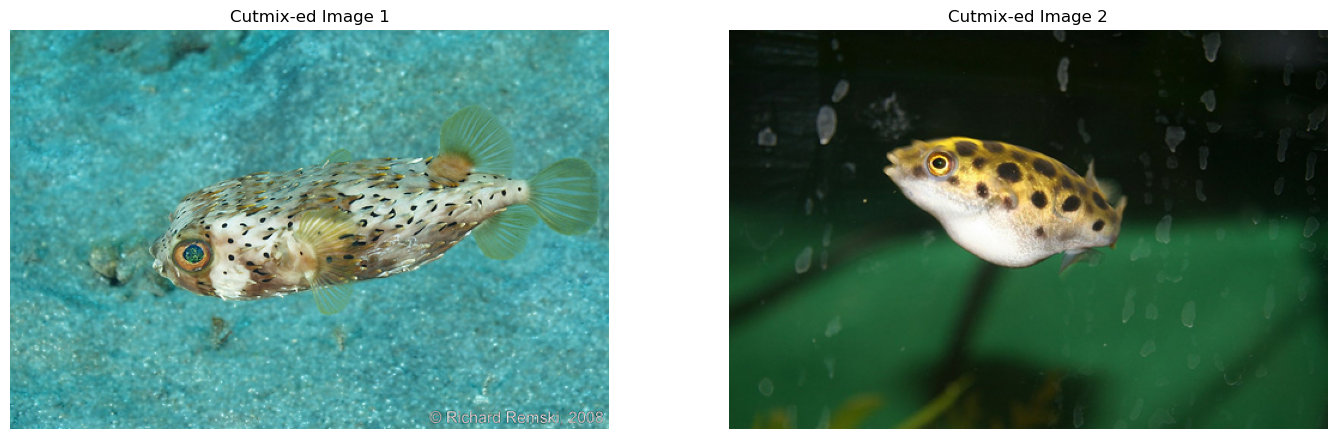

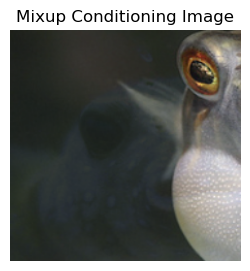

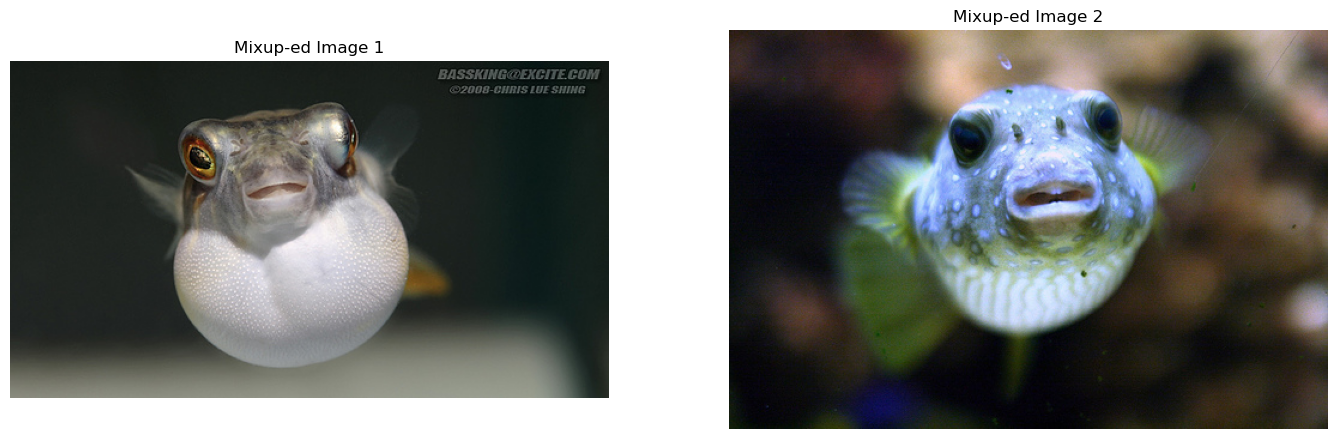

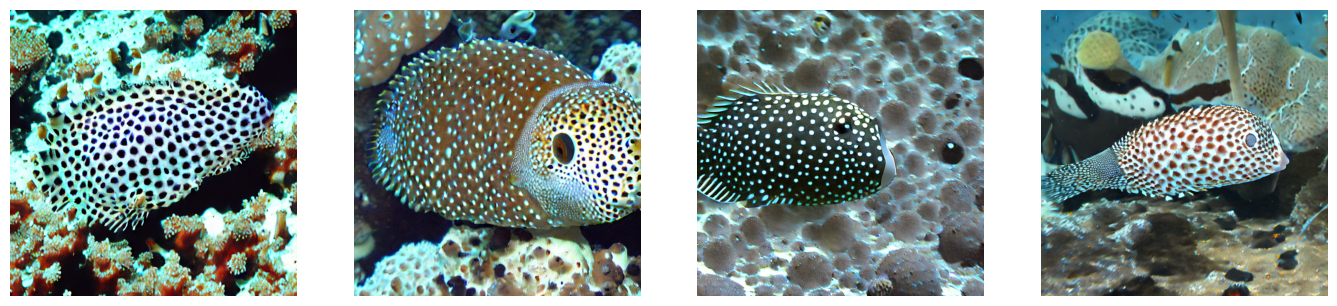

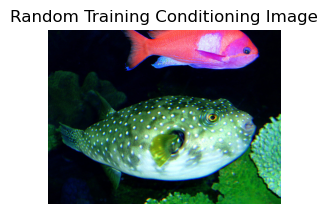

In [40]:
gen_imgs(397)

In [ ]:
gen_imgs(965)

  0%|          | 0/21 [00:00<?, ?it/s]